In [2]:
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.utils.data as Data
import numpy as np
import matplotlib.pyplot as plt
import yaml

from data.sirst import IRSTD1kDataset, NUDTDataset

from utils.grad_expand_utils import *
from utils.adaptive_filter import *
from utils.utils import compute_weighted_mean_variance, keep_negative_by_top2_magnitude_levels, \
    add_uniform_points_v3

In [30]:
# cfg
cfg_path = './cfg.yaml'
with open(cfg_path) as f:
    cfg = yaml.safe_load(f)

# # dataset
file_name = '_target'

# trainset = NUDTDataset(base_dir=r"W:/DataSets/ISTD/NUDT-SIRST", mode="train", base_size=256, pt_label=True, \
#                         pesudo_label=True, augment=False, turn_num=0, file_name=file_name, cfg=cfg)
# img_path = "W:/DataSets/ISTD/NUDT-SIRST/trainval/images" 
# elif args.dataset == 'sirstaug':
#     trainset = SirstAugDataset(base_dir=r'./datasets/sirst_aug',
#                                mode='train', base_size=args.base_size)  # base_dir=r'E:\ztf\datasets\sirst_aug'
trainset = IRSTD1kDataset(base_dir=r"W:/DataSets/ISTD/IRSTD-1k", mode="train", base_size=512, pt_label=True, \
                            pseudo_label=True, augment=False, turn_num=0, file_name=file_name, cfg=cfg)
img_path = "W:/DataSets/ISTD/IRSTD-1k/trainval/images"
    
    
train_data_loader = Data.DataLoader(trainset, batch_size=32, shuffle=False, drop_last=False)

In [ ]:
# # ================== 2. 初始化统计变量（定义在循环外，实现持续性统计）==================
# num_bins = 100
# histogram = torch.zeros(num_bins, dtype=torch.int64)  # 用于累计每个区间的计数

# # 区间边界：[0.0, 0.01), [0.01, 0.02), ..., [0.99, 1.0]
# bin_edges = torch.linspace(0.0, 1.0, steps=num_bins + 1)  # 101 个点，划分 100 个区间

# global histogram

# img_gradient_1 = (img_gradient_1 - img_gradient_1.min())/(img_gradient_1.max() - img_gradient_1.min() + 1e-11)
# img_gradient_2 = (img_gradient_2 - img_gradient_2.min())/(img_gradient_2.max() - img_gradient_2.min() + 1e-11)
# img_gradient_3 = (img_gradient_3 - img_gradient_3.min())/(img_gradient_3.max() - img_gradient_3.min() + 1e-11)
# # 使用 torch.bucketize 找到每个值所属的 bin 索引
# indices = torch.bucketize(img_gradient_1, bin_edges, right=False) - 1  # 减1是因为 bucketiz

# # 处理边界情况：值为 1.0 会被分到 index=100，减1后为99，但前面已经排除了 1.0
# # 过滤掉越界索引（理论上不会出现，但保险起见）
# indices = indices[(indices >= 0) & (indices < num_bins)]

# # 使用 torch.bincount 更新 histogram
# if len(indices) > 0:
#     counts = torch.bincount(indices, minlength=num_bins)
#     histogram += counts.cpu()
# # 使用 torch.bucketize 找到每个值所属的 bin 索引
# indices = torch.bucketize(img_gradient_2, bin_edges, right=False) - 1  # 减1是因为 bucketiz

# # 处理边界情况：值为 1.0 会被分到 index=100，减1后为99，但前面已经排除了 1.0
# # 过滤掉越界索引（理论上不会出现，但保险起见）
# indices = indices[(indices >= 0) & (indices < num_bins)]

# # 使用 torch.bincount 更新 histogram
# if len(indices) > 0:
#     counts = torch.bincount(indices, minlength=num_bins)
#     histogram += counts.cpu()
# # 使用 torch.bucketize 找到每个值所属的 bin 索引
# indices = torch.bucketize(img_gradient_3, bin_edges, right=False) - 1  # 减1是因为 bucketiz

# # 处理边界情况：值为 1.0 会被分到 index=100，减1后为99，但前面已经排除了 1.0
# # 过滤掉越界索引（理论上不会出现，但保险起见）
# indices = indices[(indices >= 0) & (indices < num_bins)]

# # 使用 torch.bincount 更新 histogram
# if len(indices) > 0:
#     counts = torch.bincount(indices, minlength=num_bins)
#     histogram += counts.cpu()

In [77]:
def gradient_expand_one_size(region, scale_weight=[0.5, 0.5, 0.5], target_mask=None, alpha=0.5, beta=0.8, view=False):
    # 归一化区域像素，以形成更强烈的边缘
    region_ = (region - region.min())/(region.max() - region.min())
    # 梯度形成
    img_gradient_1 = img_gradient2(region_)  # 2*2 sober
    img_gradient_2 = img_gradient3(region_)  # 3*3 sober
    img_gradient_3 = img_gradient5(region_)  # 5*5 sobel
    
    # 梯度映射，突出中灰度的区分度
    img_gradient_1, img_gradient_2, img_gradient_3 = sigmoid_mapping3(img_gradient_1, 10), \
         sigmoid_mapping3(img_gradient_2, 10), sigmoid_mapping3(img_gradient_3, 10)
    # 多尺度融合
    img_gradient_ = grad_multi_scale_fusion(img_gradient_1, scale_weight[0]) * grad_multi_scale_fusion(img_gradient_2, scale_weight[0]) * \
        grad_multi_scale_fusion(img_gradient_3, scale_weight[0])
    # 使用target_mask来增强对应区域的梯度
    if target_mask is not None:
        img_gradient_ = alpha + (img_gradient_ - img_gradient_.min())/(img_gradient_.max() - img_gradient_.min() + 1e-11) * (1 - alpha)   # 变换
        target_mask = beta + (target_mask - target_mask.min())/(target_mask.max() - target_mask.min() + 1e-11) * (1 - beta)
        img_gradient_ = img_gradient_ * target_mask.unsqueeze(0).unsqueeze(0)   # (1,24,H,W) *(1,1,H,W)
    img_gradient_ = (img_gradient_ - img_gradient_.min())/(img_gradient_.max() - img_gradient_.min() + 1e-11)

    # 用单像素宽度的梯度替代模糊边缘的宽的梯度
    grad_mask = local_max_gradient(img_gradient_)
    img_gradient_4 = grad_mask * img_gradient_

    # 扩展梯度
    grad_boundary = boundary4gradient_expand(img_gradient_4, 1e3)
    expanded_grad = img_gradient_4
    region_size = region.shape[2] if region.shape[2] > region.shape[3] else region.shape[3]
    for z in range(region_size):
        expanded_grad_ = gradient_expand_one_step(expanded_grad)
        expanded_grad_ += grad_boundary
        expanded_grad_ = torch.where(expanded_grad > expanded_grad_, expanded_grad, expanded_grad_) * (expanded_grad_ > -1e-4)
        expanded_grad = expanded_grad_

        # for show
        target_angle_idx = 1
        expand0 = expanded_grad[:,target_angle_idx].clone()
        grad_0 = (img_gradient_4[:,target_angle_idx].clone()).float()
        grad_12 = (img_gradient_4[:,target_angle_idx+12].clone()).float()
        expand0 = torch.clamp_min(expand0, 0)
        pict_rgb = torch.cat([grad_12 + expand0*~(grad_12 > 0.001)*~(grad_0 > 0.001), expand0*~(grad_12 > 0.001)*~(grad_0 > 0.001), expand0*~(grad_12 > 0.001)*~(grad_0 > 0.001) + grad_0])
        plt.figure(figsize=(5, 5))
        plt.imshow(pict_rgb.permute(1,2,0))
        # plt.imshow(grad_expand[0,12], cmap='gray')
        plt.show()
        a = input()

    # # for show
    # # target_angle_idx = 1
    # # expand0 = expanded_grad[:,target_angle_idx].clone()
    # # grad_0 = (img_gradient_4[:,target_angle_idx].clone() > 0.1).float()
    # # grad_12 = (grad_boundary[:,target_angle_idx].clone() * -1e-3 > 0.1).float()
    # # expand0 = torch.clamp_min(expand0, 0)
    # # pict_rgb = torch.cat([expand0+grad_12, expand0,expand0+grad_0])
    # plt.figure(figsize=(5, 5))
    # # plt.imshow(pict_rgb.permute(1,2,0))
    # plt.imshow(expanded_grad[0,0], cmap='gray')
    # plt.show()

    # # plt.figure(figsize=(5, 5))
    # # plt.imshow(expanded_grad[0, 2], cmap='gray')
    # # plt.show()

    _target = torch.sum(expanded_grad[0], dim=0)
    _target = (_target - _target.min())/(_target.max() - _target.min())

    _expanded_grad = (expanded_grad - expanded_grad.min())/(expanded_grad.max() - expanded_grad.min())

    return _target, img_gradient_4

In [78]:
def initial_target(grad_intensity: torch.Tensor, pt_label: torch.Tensor, threshold: float = 0.1):
        """
        Args:
            grad_intensity: 输入图像 [H, W]
            threshold: 阈值，用于初步划分种子点是否为有效种子点，如前景种子点需>threshold，背景种子点需<threshold
        Returns:
            seed_cofidence: 概率图 [H, W, 2]
        """
        H, W = grad_intensity.shape

        # 找局部最高值，再梯度强度➗局部最大值，进行局部归一化
        local_max = F.max_pool2d(grad_intensity.unsqueeze(0).unsqueeze(0), (5,5), stride=1, padding=2)
        local_norm_GI = grad_intensity / (local_max + 1e-11)

        # 局部最大值
        local_max2 = F.max_pool2d(local_norm_GI, (3,3), stride=1, padding=1)
        summit_mask = (local_norm_GI == local_max2)
        local_norm_GI = local_norm_GI.squeeze(0).squeeze(0)
        summit_mask = summit_mask.squeeze(0).squeeze(0)

        fg_area = (grad_intensity > threshold).float()
        bg_area = (grad_intensity < 0.1).float()

        noise_ratio = 0.05
        converge_time = 0
        for iter1 in range(50):
            fg_mask = add_uniform_points_v3(grad_intensity, fg_area > 0.1, torch.zeros_like(fg_area, dtype=torch.bool), 9, mode='bg')
            bg_mask = add_uniform_points_v3(grad_intensity, bg_area > 0.1, torch.zeros_like(bg_area, dtype=torch.bool), int(9 * bg_area.sum()/fg_area.sum()), mode='bg')
            for iter2 in range(100):
                noise = torch.rand(grad_intensity.shape)
                GI = grad_intensity * (1-noise_ratio) + noise * noise_ratio
                fig = plt.figure(figsize=(20, 5))
                # plt.subplot(1, 7, 1)
                # plt.imshow(GI.view(H, W), cmap='gray', vmax=1.0, vmin=0.0)
                # plt.subplot(1, 7, 2)
                # plt.imshow(fg_mask.view(H, W), cmap='gray', vmax=1.0, vmin=0.0)
                # plt.subplot(1, 7, 3)
                # plt.imshow(bg_mask.view(H, W), cmap='gray', vmax=1.0, vmin=0.0)

                max_num = np.ceil(fg_mask.sum().item())
                min_num = np.ceil(bg_mask.sum().item())

                if max_num > 3 and min_num > 5:
                    fg_ratio = 1 - max_num /(fg_area.sum() + 1e-8)
                    bg_ratio = 1 - min_num /(bg_area.sum() + 1e-8)
                    fg_ratio = max(fg_ratio, 0.20)
                    bg_ratio = max(bg_ratio, 0.20)

                    local_max_num = 4 if max_num * fg_ratio < 4 else max_num * fg_ratio
                    _, fg_vwo, _, fg_v = compute_weighted_mean_variance(GI, fg_mask > 0.1, int(local_max_num))

                    local_min_num = 6 if min_num * bg_ratio < 6 else min_num * bg_ratio
                    _, bg_vwo, _, bg_v = compute_weighted_mean_variance(GI, bg_mask > 0.1, int(local_min_num))
                    # print(local_max_num, local_min_num)
                    result_ = fg_v/(fg_vwo+1e-8) - bg_v/(bg_vwo+1e-8)   #(H,W)
                    # result_ = keep_negative_by_top2_magnitude_levels(result_)

                    # print(GI)
                    # print("result_")
                    # print(result_)
                    # print(fg_vwo)
                    # print(bg_vwo)
                    # print((fg_v/(fg_vwo+1e-8) - 1))
                    # print((bg_v/(bg_vwo+1e-8) - 1))

                    # plt.subplot(1, 7, 4)
                    # plt.imshow((bg_v/(bg_vwo+1e-8)-1), cmap='gray')
                    # plt.subplot(1, 7, 5)
                    # plt.imshow((fg_v/(fg_vwo+1e-8)-1), cmap='gray')
                    # plt.title(f'max{bg_vwo.max():3e}, min{bg_vwo.min():3e}')

                    # plt.subplot(1, 4, 1)
                    # plt.imshow(fg_mask, cmap='gray', vmax=0.24, vmin=0.),  plt.axis('off')
                    # plt.subplot(1, 4, 2)
                    # plt.imshow(bg_mask, cmap='gray', vmax=0.24, vmin=0.),  plt.axis('off')

                    # plt.subplot(1, 4, 3)
                    # plt.imshow(bg_v, cmap='gray', vmax=0.24, vmin=0.),  plt.axis('off')
                    # plt.subplot(1, 4, 4)
                    # plt.imshow(fg_v, cmap='gray', vmax=0.24, vmin=0.),  plt.axis('off')
                    # plt.show()
                    # a = input()
                else:
                    result_ = torch.where(fg_area > 0.1, -GI, GI)
                result_ = keep_negative_by_top2_magnitude_levels(result_, target_size=fg_area.sum())
                result = torch.where(result_ < 0., torch.ones_like(GI), torch.zeros_like(GI)).bool()
                # result = filter_mask_by_points(result, pt_label, kernel_size=5).bool()


                fg_seed_num = int(0.1*max_num)
                fg_seed_num = fg_seed_num if fg_seed_num > 2 else 2
                # if fitted != 1:
                fg_mask_new = add_uniform_points_v3(GI, (fg_area > 0.1) * (result_ < 0.), fg_mask>0.1, int(fg_seed_num), mode='fg')
                # else:
                # fg_mask_new = add_uniform_points_cuda((fg_area > 0.1) * (result_ < 0.), fg_mask>0.1, int(fg_seed_num))
                fg_mask_new = fg_mask_new.bool() * result

                bg_seed_num = int(0.1*min_num)
                bg_seed_num = bg_seed_num if bg_seed_num > 8 else 8
                # if fitted != 1:
                # bg_mask_new = add_uniform_points_cuda((bg_area > 0.1) * (result_ >= 0.), bg_mask>0.1, int(bg_seed_num))
                bg_mask_new = add_uniform_points_v3(GI, (bg_area > 0.1) * (result_ >= 0.), bg_mask>0.1, int(bg_seed_num), mode='bg')
                # else:
                # bg_mask_new = add_uniform_points_cuda((bg_area > 0.1) * (result_ > 0.), bg_mask>0.1, int(bg_seed_num))
                bg_mask_new = bg_mask_new.bool() * ~result

                diff = torch.norm(fg_mask_new.float() - (fg_mask > 0.1).float()) 
                if diff < 1:
                    # print(f"iter1 {iter1} iter2 Converged at {iter2}")
                    break
                # else:
                #     print(f"iter1 {iter1} iter2 {iter2}, Diff: {diff}")

                plt.subplot(1, 4, 3)
                plt.imshow(fg_mask_new, cmap='gray'),  plt.axis('off')
                plt.subplot(1, 4, 4)
                plt.imshow(result, cmap='gray'),  plt.axis('off')
                plt.subplot(1, 4, 2)
                plt.imshow(bg_mask_new, cmap='gray'),  plt.axis('off')
                plt.show()
                a = input()

                decay_rate = 0.8
                fg_mask, bg_mask = fg_mask_new.float() + fg_mask*decay_rate, bg_mask_new.float() + bg_mask*decay_rate
                fg_mask, bg_mask = torch.clamp(fg_mask, min=0.0, max=1.0), torch.clamp(bg_mask, min=0.0, max=1.0)
            
            # fig = plt.figure(figsize=(15, 5))
            # plt.subplot(1, 3, 1)
            # plt.imshow(GI.view(H, W), cmap='gray', vmax=1.0, vmin=0.0)
            # plt.subplot(1, 3, 2)
            # plt.imshow(result, cmap='gray', vmax=1.0, vmin=0.0)
            # plt.subplot(1, 3, 3)
            # plt.imshow(fg_area, cmap='gray', vmax=1.0, vmin=0.0)
            # plt.show(block=False)
            # a = input()
            # 修改area
            # result = filter_mask_by_points(result, pt_label, kernel_size=5).bool()
            # print(f"iter2 Converged at{iter2}, Diff: {diff}")
            fg_area_new = result
            bg_area_new = ~result
            diff = torch.norm(bg_area_new.float() - bg_area.float())
            if diff < (H * W / 64) ** 0.5:
                converge_time += 1
                # print(f"iter1 Converged at{iter1}, Diff: {diff}")
            if converge_time > 3:
                break
            # else:
            #     print(f"iter1 {iter1}, Diff: {diff}")
            if result.float().sum() < 4:
                noise_ratio = noise_ratio * 0.5
                continue
            noise_ratio = noise_ratio * 0.9
            if fg_area_new.sum() > (grad_intensity > 0.1).float().sum() * 2 and (H + W) > 96:
                break
            decay_rate = 0.5
            fg_area, bg_area = fg_area_new.float() + fg_area*decay_rate, bg_area_new.float()+ bg_area*decay_rate
            fg_area, bg_area = torch.clamp(fg_area, min=0.0, max=1.0), torch.clamp(bg_area, min=0.0, max=1.0)

        return result

In [79]:
def gradient_expand_filter_v2(img, pt_label, region_size, view=False):
    B, _, H, W = img.shape
    indices = torch.where(pt_label > 1e-4)
    output = torch.zeros_like(img, dtype=torch.float32)
    for b, _, s1, s2 in zip(*indices):
        # 提取区域
        targets = []
        for i in range(len(region_size)):
            _region_size = region_size[i]
            # 计算区域坐标（y1, x1)(y2, x2)
            y1 = max(1, s1 - _region_size // 2)
            x1 = max(1, s2 - _region_size // 2)
            y2 = min(H-1, s1 + (_region_size - _region_size // 2))
            x2 = min(W-1, s2 + (_region_size - _region_size // 2))
            _region = img[b:b+1,:1, y1:y2, x1:x2]

            _target, grad_expand = gradient_expand_one_size(_region, [0.5, 0.5, 0.5], view=view)
            targets.append({'target':_target, 'coor':(y1,x1,y2,x2)})

            # _target_fg = torch.where(_target > 0.5, torch.tensor([1.,]), torch.tensor([0.,]))
            # _target_bg = torch.where(_target < 0.1, torch.tensor([-1.,]), torch.tensor([0.,]))
            # target = _target_fg + _target_bg

            # plt.figure(figsize=(5, 5))
            # plt.imshow(target, cmap='gray', vmax=1.0, vmin=-1.0)
            # # plt.imshow(_region[0,0], cmap='gray', vmax=1.0, vmin=-1.0)
            # plt.show()

            # # for show
            # target_angle_idx = 1
            # expand0 = grad_expand[:,target_angle_idx].clone()
            # grad_0 = (grad_expand[:,target_angle_idx].clone()).float()
            # grad_12 = (grad_expand[:,target_angle_idx+12].clone()).float()
            # expand0 = torch.clamp_min(expand0, 0)
            # pict_rgb = torch.cat([grad_12, torch.zeros_like(expand0),grad_0])
            # plt.figure(figsize=(5, 5))
            # plt.imshow(pict_rgb.permute(1,2,0))
            # # plt.imshow(grad_expand[0,12], cmap='gray')
            # plt.show()
        
        # final_target, scores, coors = finalize_target(targets, view)

        # fig = plt.figure(figsize=(15, 5))
        # plt.subplot(1, 3, 1)
        # plt.imshow(final_target, cmap='gray', vmax=1.0, vmin=0.0)
        # plt.subplot(1, 3, 2)
        # plt.imshow(final_target, cmap='gray', vmax=0.1, vmin=0.0)
        # plt.subplot(1, 3, 3)
        # plt.imshow(img[b,0, coors[0]:coors[2], coors[1]:coors[3]], cmap='gray', vmax=1.0, vmin=0.0)
        # plt.show()
        
        # target_filtered__ = initial_target(final_target, pt_label[b,0, coors[0]:coors[2], coors[1]:coors[3]], threshold=0.5)
        # target_filtered_by_points = filter_mask_by_points(target_filtered__, pt_label[b,0, coors[0]:coors[2], coors[1]:coors[3]]) # (uint8)
        # target_refined = target_filtered_by_points
        
        # output[b,0, coors[0]:coors[2], coors[1]:coors[3]] = torch.max(output[b,0, coors[0]:coors[2], coors[1]:coors[3]], target_refined)
    return output

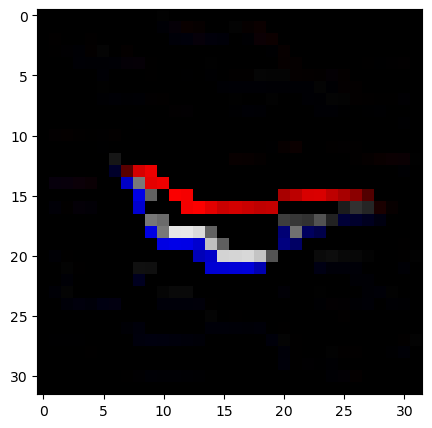

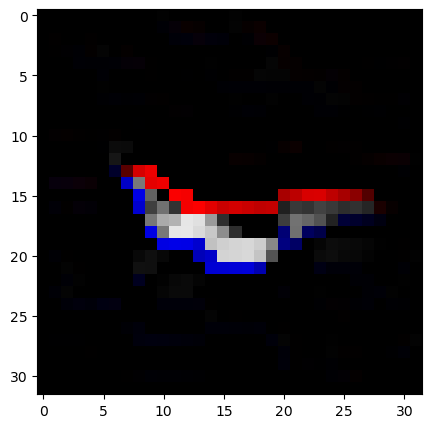

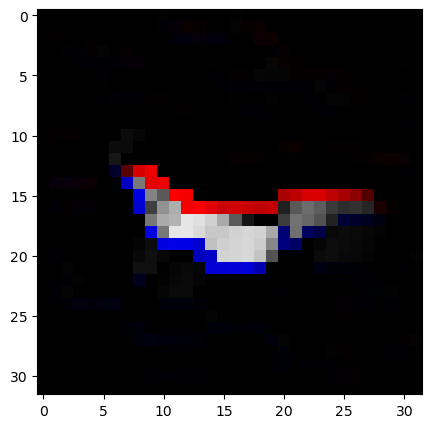

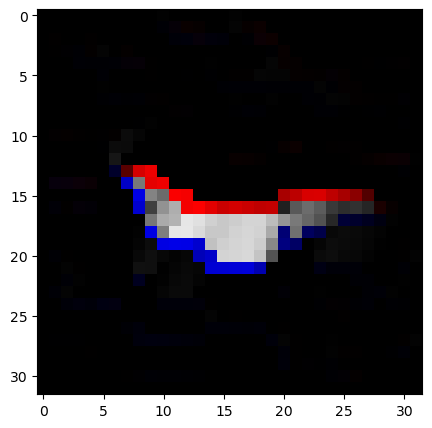

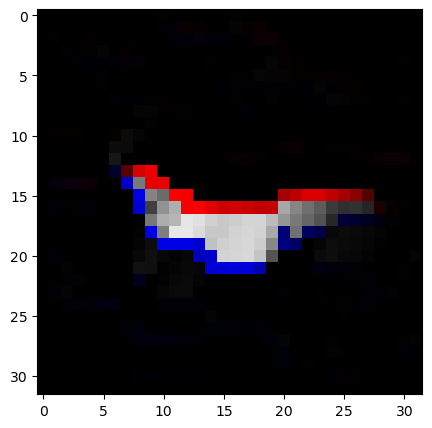

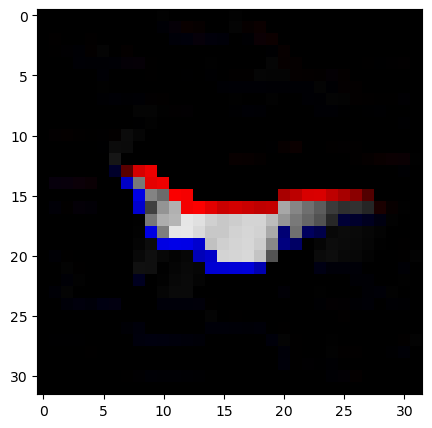

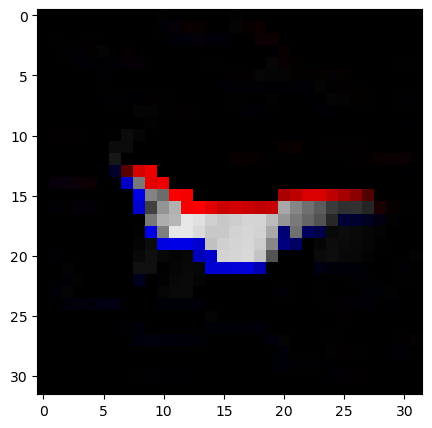

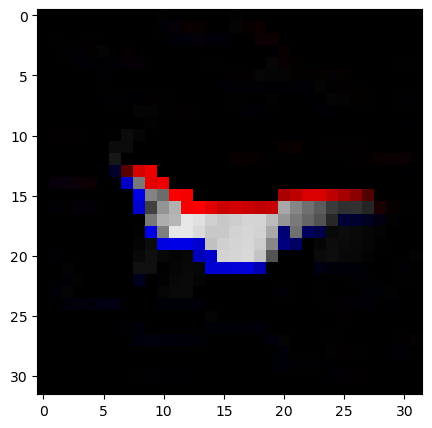

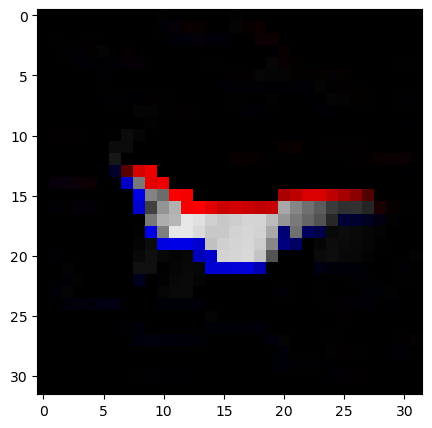

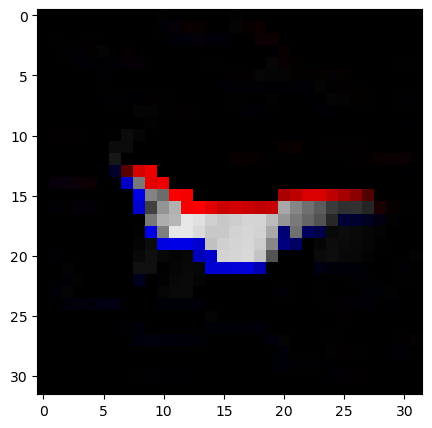

KeyboardInterrupt: Interrupted by user

In [80]:
for j, (img, label) in enumerate(train_data_loader):
    pt_label, pesudo_label = label[:,0:1], label[:,1:2]
    B, _, H, W = img.shape
    indices = torch.where(pt_label > 1e-4)

    target_grad_expanded_filtered = gradient_expand_filter_v2(img, pt_label, [32,48,64], view=0)


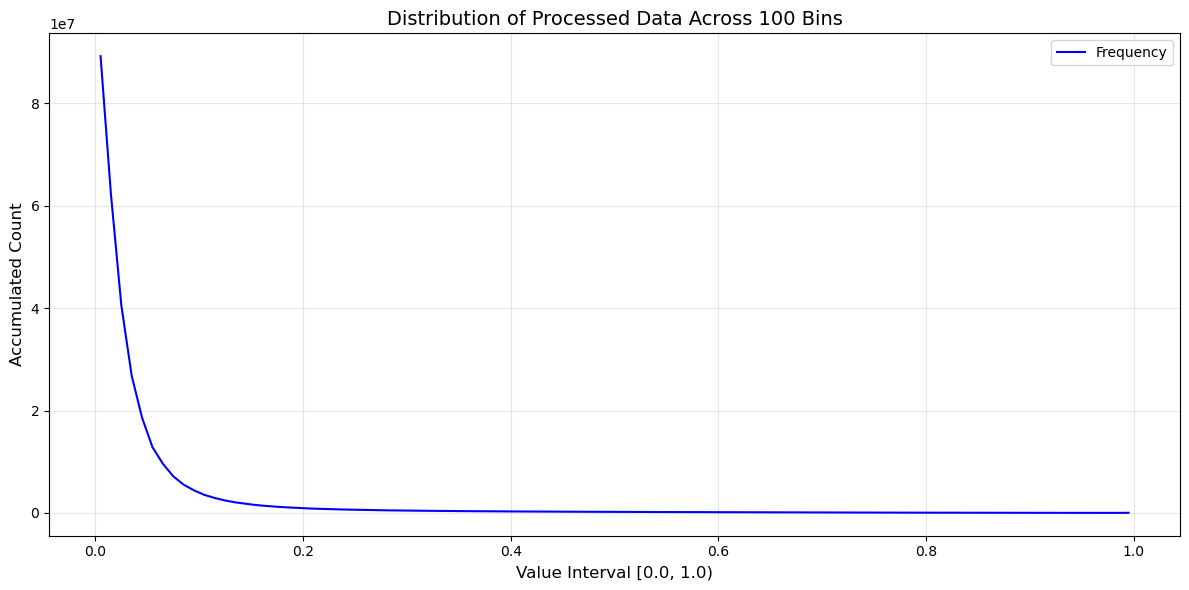

In [19]:
# ================== 4. 绘图 ==================
plt.figure(figsize=(12, 6))
bins_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # 每个区间的中心点作为横坐标
plt.plot(bins_centers.numpy(), histogram.numpy(), color='blue', linewidth=1.5, label='Frequency')
plt.xlabel('Value Interval [0.0, 1.0)', fontsize=12)
plt.ylabel('Accumulated Count', fontsize=12)
plt.title('Distribution of Processed Data Across 100 Bins', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [1]:
# ================== 4. 绘图（使用对数坐标轴）==================
plt.figure(figsize=(12, 6))
bins_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # 每个区间的中心

# 绘制折线图
plt.plot(bins_centers.numpy(), histogram.numpy(), 
         color='blue', linewidth=1.5)

# 👇 关键：设置 y 轴为对数刻度
plt.yscale('log')

plt.xlabel('Gradient Intensity [0.0, 1.0)', fontsize=12)
plt.ylabel('Pixel Count (log scale)', fontsize=12)
# plt.title('Distribution of Processed Data Across 100 Bins (Log Scale)', fontsize=14)
plt.grid(True, alpha=0.3, which="both")  # 同时显示主次网格
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


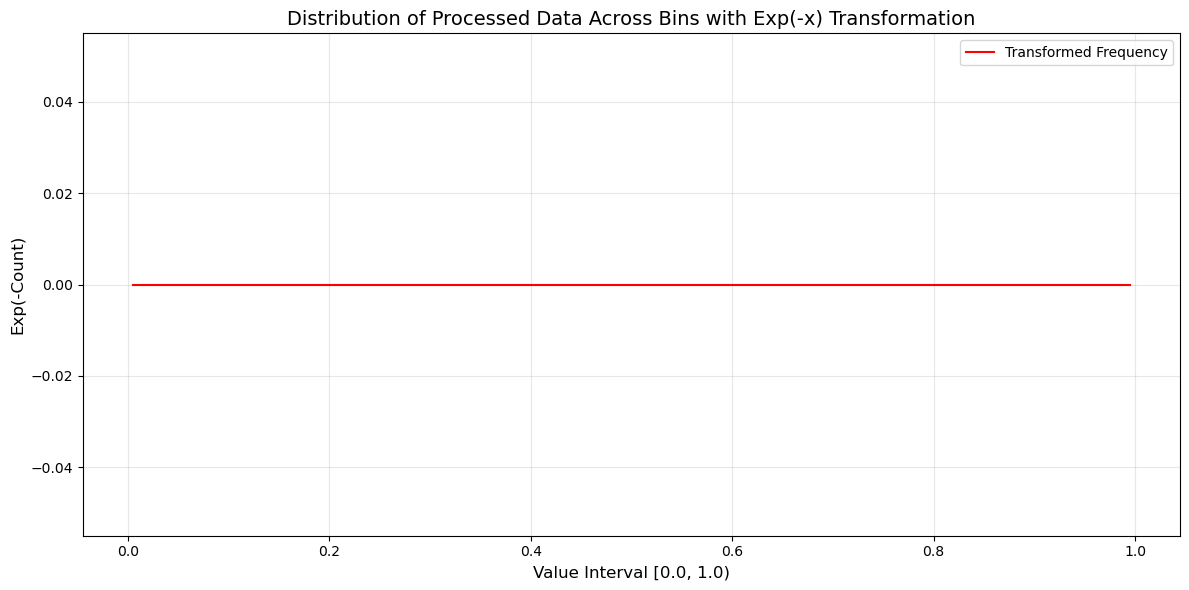

In [24]:
# 对纵坐标进行 y=exp(-x) 处理
transformed_histogram = np.exp(-histogram.numpy())
print(transformed_histogram)

# 创建图形
plt.figure(figsize=(12, 6))

# 绘制折线图
plt.plot(bins_centers, transformed_histogram, color='red', linewidth=1.5, label='Transformed Frequency')

# 设置图表信息
plt.xlabel('Value Interval [0.0, 1.0)', fontsize=12)
plt.ylabel('Exp(-Count)', fontsize=12)
plt.title('Distribution of Processed Data Across Bins with Exp(-x) Transformation', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

# 显示图表
plt.show()

In [1]:
from PIL import Image
import numpy as np
import os
import os.path as osp


from utils.evaluation import SegmentationMetricTPFNFP

In [7]:
pesudo_mask_dir = "W:/DataSets/ISTD/NUDT-SIRST/trainval/pixel_pseudo_label1.67_acm"
mask_dir = "W:/DataSets/ISTD/NUDT-SIRST/trainval/masks"
# pesudo_mask_dir = "W:/DataSets/ISTD/IRSTD-1k/trainval/pixel_pseudo_label0.41"
# mask_dir = "W:/DataSets/ISTD/IRSTD-1k/trainval/masks"
names = os.listdir(mask_dir)

metric = SegmentationMetricTPFNFP(nclass=1)

for name in names:
    mask_path = osp.join(mask_dir, name)
    pesudo_mask_path = osp.join(pesudo_mask_dir, name)

    mask = Image.open(mask_path).convert('L')
    # mask = Image.open(mask_path).convert('L').resize((256, 256), Image.NEAREST)
    pesudo_mask = Image.open(pesudo_mask_path).convert('L') 

    mask, pesudo_mask = np.array(mask).astype(np.float32) / 255., np.array(pesudo_mask).astype(np.float32) / 255.
    # pesudo_mask 设置阈值使得其为二值图
    pesudo_mask = (pesudo_mask > 0.1).astype(np.float32)
    
    metric.update(mask, pesudo_mask)

base_log = "pesudo_mask quality, mIoU: {:.4f}, prec: {:.4f}, recall: {:.4f}, F1: {:.4f} "
iou , prec, recall, f1 = metric.get()
print(base_log.format(iou , prec, recall, f1))

pesudo_mask quality, mIoU: 0.7034, prec: 0.8687, recall: 0.7871, F1: 0.8259 


In [2]:
np.load("W:/Projects/WeakSupervisedIRSTD/others_pseudo_label_g/SIRST-Single-Point-Supervision-main/dataset/final_dataset_final/NUAA-SIRST/image_info/Misc_1.npy", allow_pickle=True)

array({'name': 'Misc_1', 'Ymin_f': [69, 129], 'Ymax_f': [79, 138], 'Xmin_f': [67, 216], 'Xmax_f': [73, 223], 'centroid_label_y': [74, 133], 'centroid_label_x': [70, 220], 'target_type': ['Point', 'Point']},
      dtype=object)